In [1]:
import pandas as pd
import json
import regex as re
import random
import datetime
import requests
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [3]:
def get_monthly_archives(username):
    '''Returns a list of months in which the user played a game'''
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        months_played = json.loads(response.content.decode('utf-8'))['archives']
        return [month[-7:].split('/') for month in months_played]
    except:
        return []
        
def get_player_games(username):
    '''return a list of all games played'''
    
    months = get_monthly_archives(username)
    games = []
    if months:
        for month in months:
            year = month[0]
            month_ = month[1]
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month_}')
            for game in json.loads(response.content.decode('utf-8'))['games']:
                games.append(game)
    return games

def game_stats_df(username):
    '''Returns a pandas dataframe containing stats for every game played'''
    
    game_list = get_player_games(username)
    
    player_rating = []
    rating_difference = []
    player_result = []
    player_username = []
    end_time = []
    pgn = []
    eco = []
    rated = []
    time_class = []
    rules = []
    game_length = []
    player_color = []

    for i, game in enumerate(game_list):
        
        starting_position = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'
        
        if (game['rules'] == 'chess') and (game['fen'] != starting_position):
            pgn_data = game['pgn'].split('\n')
            pgn.append(pgn_data[-1])
            eco.append(pgn_data[7].split('"')[-2])
            game_length.append(int(re.split("(\d+)\.+", game['pgn'])[-2]))

        else:
            pgn.append(None)
            eco.append(None)
            game_length.append(None)
            
        if game['black']['username'].lower() == username.lower():
            player_rating.append(game['black']['rating'])
            rating_difference.append(game['black']['rating'] - game['white']['rating'])
            player_result.append(game['black']['result'])
            player_username.append(game['black']['username'])
            player_color.append('black')
        else:
            player_rating.append(game['white']['rating'])
            rating_difference.append(game['white']['rating'] - game['black']['rating'])
            player_result.append(game['white']['result'])
            player_username.append(game['white']['username'])
            player_color.append('white')
            
        end_time.append(pd.to_datetime(game['end_time'], unit='s'))
        rated.append(game['rated'])
        time_class.append(game['time_class'])
        rules.append(game['rules'])

    df = pd.DataFrame({'player_username': player_username,
                       'player_color': player_color,
                       'player_rating': player_rating,
                       'rating_difference': rating_difference,
                       'player_result': player_result,
                       'end_time': end_time,
                       'rated': rated,
                       'time_class': time_class,
                       'rules': rules,
                       'pgn': pgn,
                       'eco': eco,
                       'game_length':game_length})
    
#     Create three columns in the data frame indicating a win, draw, or loss with a True or False
    df['win'] = df['player_result'] == 'win'

    draw = {'agreed', 'repetition', 'stalemate',
            'insufficient', '50move', 'timevsinsufficient'}
    
    df['draw'] = df['player_result'].isin(draw)

    lose = {'checkmated', 'timeout', 'resigned', 'lose', 'abandoned',
           'kingofthehill', 'threecheck'}

    df['lose'] = df['player_result'].isin(lose)
    
    return df

In [4]:
df = game_stats_df('johnstelmach')

<Container object of 1121 artists>

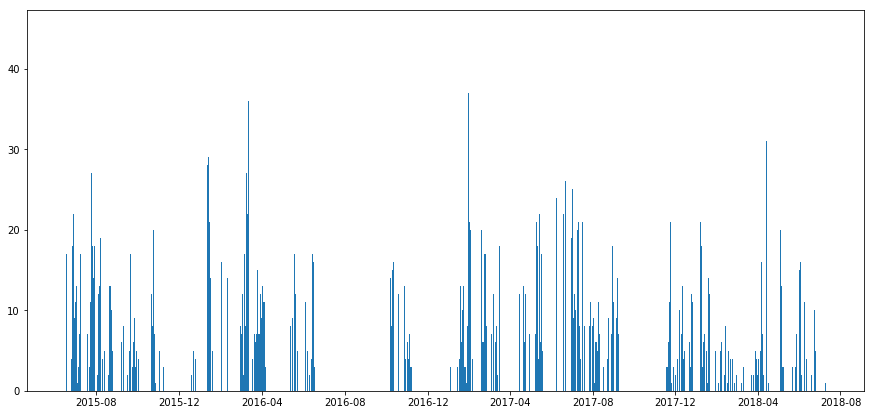

In [35]:
blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
game_amount = blitz_chess_df.resample('D', on='end_time').size().values
dates = blitz_chess_df.resample('D', on='end_time').size().index

fig, ax = plt.subplots(figsize=(15,7))

ax.bar(dates, game_amount)

In [32]:
y.mean()

3.624442462087422

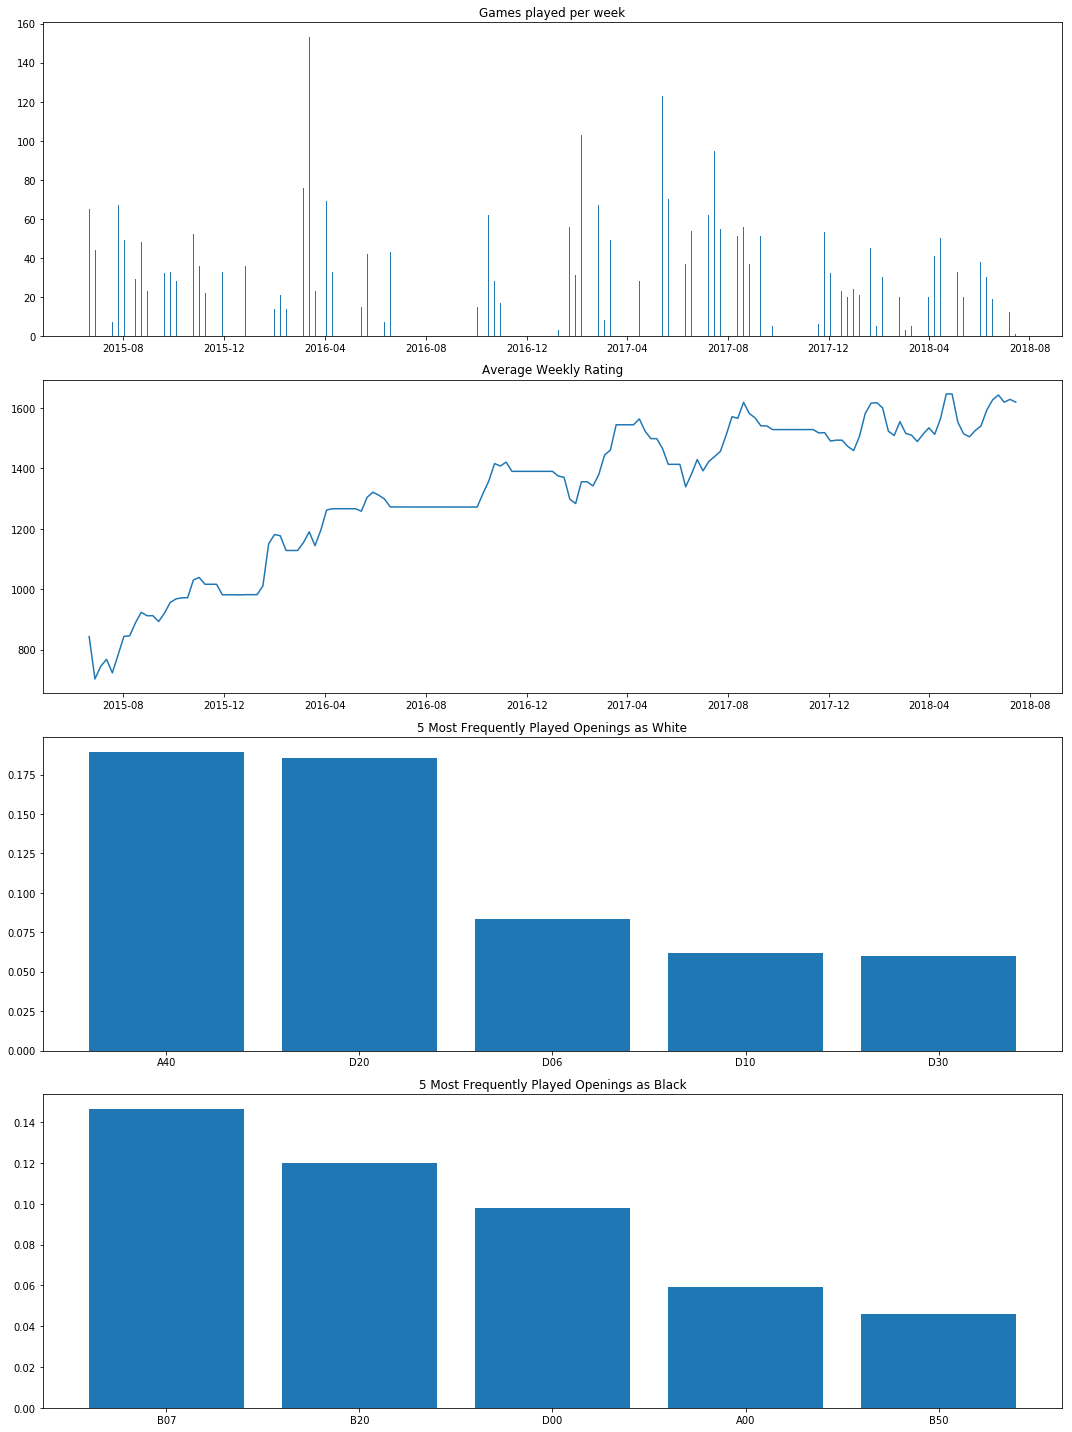

In [76]:
def chess_graphs(df, resample='W', num_openings=5):
    fig, ax = plt.subplots(4, figsize=(15, 20))

    blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
    
    game_amount = blitz_chess_df.resample(resample, on='end_time').size().values
    dates = blitz_chess_df.resample(resample, on='end_time').size().index

    ax[0].bar(dates, game_amount)
    ax[0].set_title('Games played per week')

    ax[1].plot(blitz_chess_df.resample(resample, on='end_time').mean()['player_rating'].fillna(method='ffill'))
    ax[1].set_title('Average Weekly Rating')

    games_played_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_openings].values
    openings_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_openings].index

    x = np.arange(len(openings_white))

    ax[2].bar(x, games_played_white)
    ax[2].set_title(f'{num_openings} Most Frequently Played Openings as White')
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(openings_white);

    games_played_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_openings].values
    openings_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_openings].index

    ax[3].bar(x, games_played_black)
    ax[3].set_title(f'{num_openings} Most Frequently Played Openings as Black')
    ax[3].set_xticks(x)
    ax[3].set_xticklabels(openings_black)

    fig.tight_layout();

chess_graphs(df, resample='W')

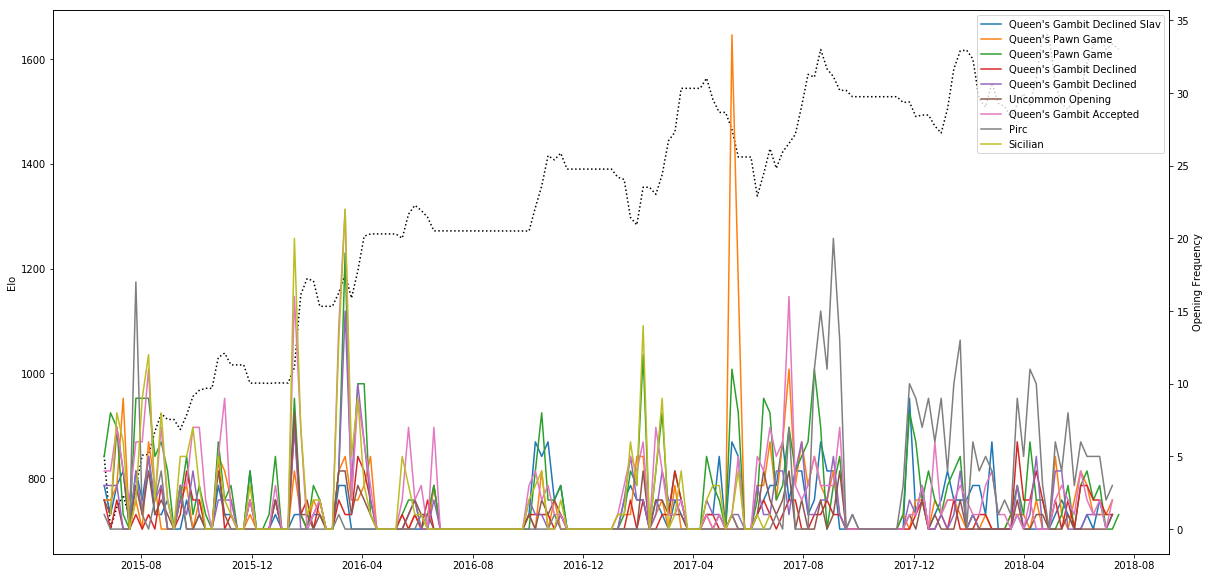

In [74]:
def openings(df, color='both', min_games=0.03, resample='W'):
    '''Return a graph of elo on the right x axis and frequency of openings played on the left axis over time (weeks)
    Params
        df: pandas dataframe
        color: Filter games by color played, white or black. Default is both.
        min_games: Filter openings displayed by a minimum percentage of total games played. Default is 3%, meaning
                   openings which were played less than 3% of the total games played are omitted'''
    
    blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]
    
    fig, ax1 = plt.subplots(figsize=(20, 10))

    ax2 = ax1.twinx()

    if color == 'both':
        color_df = blitz_chess_df
    elif (color == 'white') or (color == 'black'):
        color_df = blitz_chess_df[blitz_chess_df['player_color'] == color]

    openings = color_df['eco'].unique()

    total_games = color_df.size
    games_per_week = color_df.resample(resample, on='end_time').size()

    ax1.plot(color_df.resample(resample, on='end_time').mean()['player_rating'].fillna(method='ffill'), color='black', linestyle=':')
    ax1.set_ylabel('Elo', color='black')

    for opening in openings:
        games_with_opening = color_df[color_df['eco'] == opening].size
        percentage_of_games_with_opening = games_with_opening / total_games

        if (percentage_of_games_with_opening) > min_games:
            ax2.plot(color_df[color_df.eco == opening].resample(resample, on='end_time').size(),label=eco_names[opening])
            ax2.set_ylabel('Opening Frequency')
            ax2.legend()
            
openings(df)

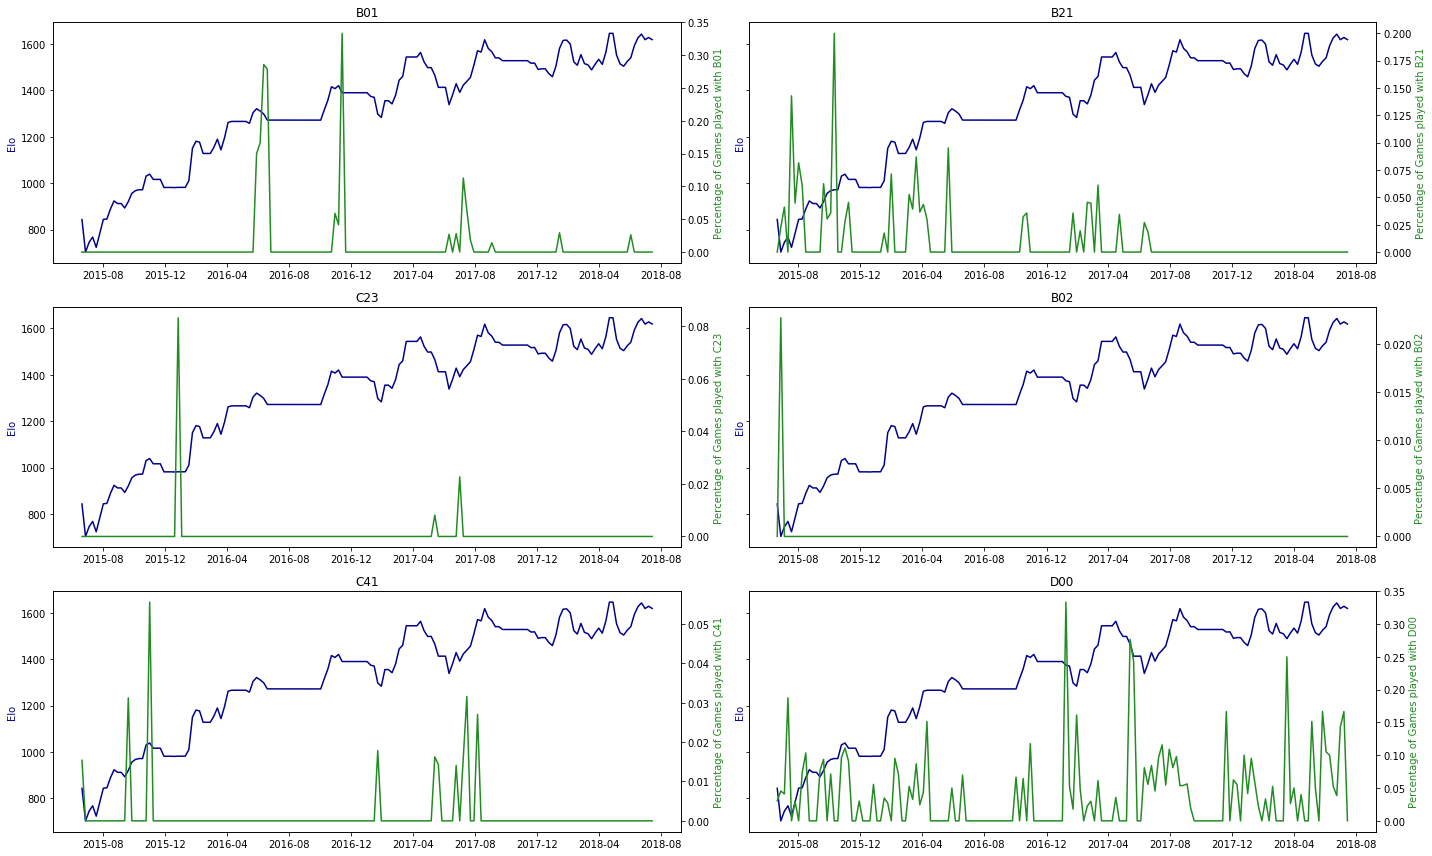

In [387]:
blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]

y_plot = int(len(popular_openings) / 2)

fig, ax1 = plt.subplots(y_plot, 2, figsize=(20, 4*y_plot), sharey='all')

for ax, opening in zip(ax1.flatten(), popular_openings):
    ax2 = ax.twinx()

    ax2.plot((blitz_chess_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size() /
              blitz_chess_df.resample('W', on='end_time').size()).fillna(0),
             'forestgreen')
    ax2.set_ylabel(f'Percentage of Games played with {opening}', color='forestgreen')

    ax.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
    ax.set_ylabel('Elo', color='darkblue')
    ax.set_title(opening)
    
    fig.tight_layout()

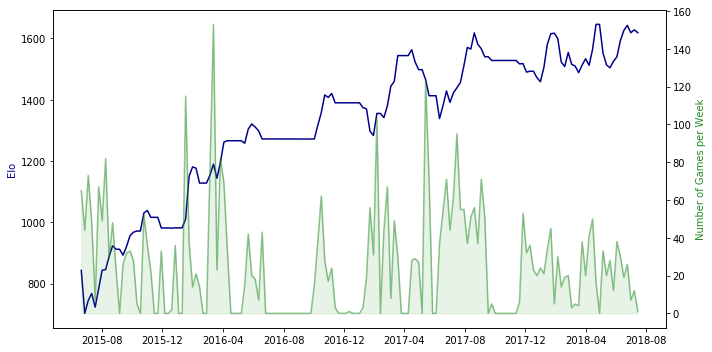

In [388]:
fig, ax1 = plt.subplots(figsize=(10,5))

x = blitz_chess_df.resample('W', on='end_time').sum().index
y = blitz_chess_df.resample('W', on='end_time').size()

ax2 = ax1.twinx()

ax2.plot(y, 'forestgreen', alpha=.5)
ax2.fill_between(x, 0, y, alpha=.1, color='forestgreen')
ax2.set_ylabel('Number of Games per Week', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')
         
fig.tight_layout()

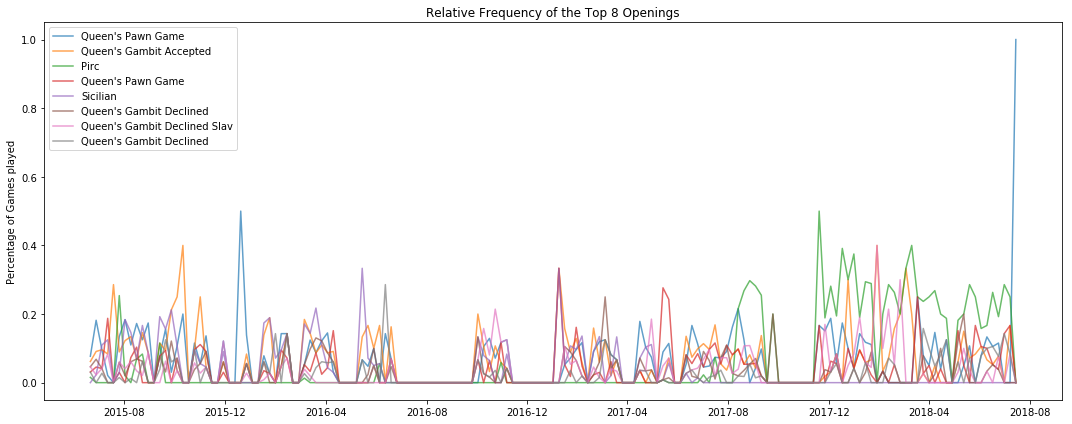

In [73]:
color_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]

openings_ = color_df['eco'].unique()
total_games = color_df.size

num_openings = 8
game_freq = []
for opening in openings_:
    games_with_opening = color_df[color_df['eco'] == opening].size
    game_freq.append(games_with_opening / total_games)

popular_openings = []
for idx in np.argsort(game_freq)[:-(num_openings+1):-1]:
    popular_openings.append(openings_[idx])

fig, ax = plt.subplots(figsize=(15, 6))

for opening in popular_openings:

    ax.plot((color_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size() /
              color_df.resample('W', on='end_time').size()).fillna(0),
           label=eco_names[opening],
           alpha=.7)
    ax.set_ylabel('Percentage of Games played')
    ax.set_title(f'Relative Frequency of the Top {num_openings} Openings')
    ax.legend()
    
    fig.tight_layout()

In [391]:
popular_openings

['A40', 'D20', 'B07', 'D00', 'B20']

In [344]:
game_freq[42]

0.054947916666666666

In [66]:
file = open('/Users/bmcgarry/galvanize/ChessCapstone/ChessStyle/data/eco_codes.txt', 'r')
eco_names = {}
for idx, line in enumerate(file):
    if idx % 2 == 0:
        eco_names[line[:3]] = line[4:-1]

In [72]:
eco_names['E09']

'Catalan, Closed'

In [85]:
#open dict of eco labels and names
with open('eco_names.json') as infile:
    eco_names = json.load(infile)